# USTG

In [4]:
pip install selfies

In [8]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import time
import pandas as pd
import selfies as sf
import re

## Data Preparation

In [ ]:
pd.options.mode.chained_assignment = None

SMILESdb = pd.read_csv('sample_db_only_smiles.csv')
print(SMILESdb.shape)
SMILESdb.head()

for el in range(len(SMILESdb.smiles)):
    try:
        SMILESdb.smiles.iloc[el] = (sf.encoder(SMILESdb.smiles[el]))
    except:
        SMILESdb.smiles.iloc[el] = ''

SMILES = SMILESdb.loc[SMILESdb['smiles'] != '']
#~7000 molecules drops out
SMILES.head(20)

s = ""
for row in range(len(SMILESdb)):
    s += SMILESdb['smiles'][row] + '\n'

with open('sample.txt', 'w') as file:
    # Zapisywanie stringa do pliku
    file.write(s)

bag_of_chem = []
for el in range(len(SMILESdb)):
    bag_of_chem += '[^]'
    bag_of_chem += SMILESdb.smiles[el]
print(bag_of_chem[:20])

## Tokenization

In [9]:
def from_selfies_to_bpe_selfies(pairs, bag_of_chem):

    sample_smiles = ''.join(bag_of_chem)
    print(len(sample_smiles))

    pattern = r"(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
    regex = re.compile(pattern)

    tokens = regex.findall(sample_smiles)

    new_token = []

    pairs = sorted(pairs, key=len, reverse=True)
    i = 0
    while i < len(tokens):
        matched_pair = None
        for pair in pairs:
            # Sprawdzamy, czy kolejne tokeny tworzą parę zdefiniowaną w pairs

            if ''.join(tokens[i:i+len(pair)]) == ''.join(pair):

                matched_pair = ''.join(pair)
                break
        if matched_pair:
            new_token.append(matched_pair)
            i += len(pair)
        else:
            new_token.append(tokens[i])
            i += 1

    return new_token

p = [['[C]', '[=C]'],
['[C]', '[C]'],
['[C]', '[=C]', '[C]', '[=C]'],
['[Branch1]', '[C]', '[C]'],
['[Ring1]', '[=Branch1]'],
['[C]', '[=C]', '[Ring1]', '[=Branch1]'],
['[Branch1]', '[C]'],
['[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]'],
['[Branch1]', '[=Branch2]'],
['[Branch1]', '[C]', '[C]', '[C]'],
['[Branch2]', '[Ring1]'],
['.[H]'],
['[C]', '[=Branch1]'],
['[H]'],
['[C]', '[Branch1]', '[C]', '[C]', '[C]'],
['[Branch1]', '[Ring1]'],
['[Branch1]', '[C]', '[C]', '[Branch1]', '[C]', '[C]', '[C]'],
['[CH0]', '[OH0]'],
['[Branch1]', '[=Branch2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]'],
['[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]'],
['[C]', '[=C]', '[Branch1]'],
['[C]', '[C]', '[C]', '[C]'],
['[Ring2]', '[Ring1]'],
['[Branch1]', '[Ring1]', '[CH0]', '[OH0]'],
['[Branch1]', '[C]', '[F]'],
['[Ring1]', '[Branch1]']]

df = from_selfies_to_bpe_selfies(p, bag_of_chem)

print(df[:10])

print(len(df))


vocab = sorted(list(set(df)), key=len, reverse=True)

char_to_token = {char:idx for idx,char in enumerate(vocab)}
token_to_char = {idx:char for char,idx in char_to_token.items()}
encode = lambda x: [char_to_token[char] for char in x]
decode = lambda idxs: ''.join([token_to_char[idx] for idx in idxs])

encoded_text = torch.tensor(encode(df))
print('Encoded Text shape:',encoded_text.shape, 'Encoded Text Dtype:', encoded_text.dtype)

train_test_split = 0.9
train_data = encoded_text[:int(train_test_split*len(encoded_text))]
valid_data = encoded_text[int(train_test_split*len(encoded_text)):]
print('Train data length:',len(train_data),'Valid data length:',len(valid_data))

(29547, 3)
['[', '^', ']', '[', 'I', 'n', ']', '[', 'B', 'r', 'a', 'n', 'c', 'h', '2', ']', '[', 'R', 'i', 'n']
10190939
['[^]', '[In]', '[Branch2][Ring1]', '[=C]', '[C]', '[Branch1][=Branch2]', '[Si]', '[Branch1][C][C][Branch1][C][C][C]', '[Branch1][=Branch2]', '[Si]']
1151877
Encoded Text shape: torch.Size([1151877]) Encoded Text Dtype: torch.int64
Train data length: 1036689 Valid data length: 115188


## Architecture

In [10]:
#whole transformer architecture

class Head(nn.Module):
    """ single head of self attention """
    def __init__(self):
        super().__init__()
        self.key_layer   = nn.Linear(in_features=EMBEDDING_DIM, out_features=HEAD_SIZE, bias=False)
        self.query_layer = nn.Linear(in_features=EMBEDDING_DIM, out_features=HEAD_SIZE, bias=False)
        self.value_layer = nn.Linear(in_features=EMBEDDING_DIM, out_features=HEAD_SIZE, bias=False)

        self.register_buffer('tril', torch.tril(torch.ones((CONTEXT_LEN, CONTEXT_LEN))))
        self.dropout = nn.Dropout(DROPOUT)
    def forward(self, x):
        B,T,C = x.shape
        q = self.query_layer(x) #(B,T,C)
        k = self.key_layer(x) #(B,T,C)
        v = self.value_layer(x) #(B,T,C)

        #compute scores based on affinities
        weights = (q @ k.transpose(-2,-1)) * HEAD_SIZE**-0.5
        weights = weights.masked_fill(self.tril[:T,:T] == 0, float('-inf'))
        weights = F.softmax(input=weights, dim=-1)
        weights = self.dropout(weights)


        out = weights @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.heads = nn.ModuleList([Head() for _ in range(NUM_HEADS)])
        self.projections = nn.Linear(EMBEDDING_DIM, EMBEDDING_DIM)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        return self.projections(out)

class Block(nn.Module):
    """Transformer Block: Communication folled by computation."""
    def __init__(self):
        super().__init__()

        self.multi_self_attention_heads_layer = MultiHeadAttention()
        self.feed_forward_network = FeedForwardNetwork(EMBEDDING_DIM)
        self.layer_norm1 = nn.LayerNorm(EMBEDDING_DIM)
        self.layer_norm2 = nn.LayerNorm(EMBEDDING_DIM)
    def forward(self, x):
        x = x + self.multi_self_attention_heads_layer(self.layer_norm1(x))
        x = x + self.feed_forward_network(self.layer_norm2(x))
        return x

class FeedForwardNetwork(nn.Module):
    """A simple linear network followed by a non-linearity"""
    def __init__(self, EMBEDDING_DIM):
        super().__init__()
        self.ffn = nn.Sequential(
            nn.Linear(in_features=EMBEDDING_DIM, out_features=EMBEDDING_DIM*4),
            nn.ReLU(),
            nn.Linear(4*EMBEDDING_DIM, EMBEDDING_DIM),
            nn.Dropout(DROPOUT)
        )
    def forward(self, x):
        return self.ffn(x)


class TransformerLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(num_embeddings=VOCAB_SIZE, embedding_dim=EMBEDDING_DIM)
        self.position_embedding_table = nn.Embedding(CONTEXT_LEN, EMBEDDING_DIM)

        self.blocks = nn.Sequential(*(Block() for _ in range(N_LAYER)))
        self.layer_norm = nn.LayerNorm(EMBEDDING_DIM)
        self.language_model_head_linear_layer = nn.Linear(EMBEDDING_DIM, VOCAB_SIZE)

    def forward(self, idx, targets=None):

        B, T = idx.shape
        token_embeddings = self.token_embedding_table(idx)
        pos_embedding = self.position_embedding_table(torch.arange(T, device=DEVICE))
        x = token_embeddings + pos_embedding #the x does not contain only information about the value of the token, but also about its position which is in line with the assumptions of the transformer architecture
        x = self.blocks(x)
        logits = self.language_model_head_linear_layer(x)

        if targets is not None:
            B,T,C = logits.shape
            logits_reshaped = logits.view(B*T,C)
            targets_reshaped = targets.view(B*T)
            loss = F.cross_entropy(input=logits_reshaped, target=targets_reshaped)
        else:
            loss=None
        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_crop = idx[:,-CONTEXT_LEN:]
            logits, loss = self(idx_crop)
            logits_last_timestep = logits[:,-1,:]
            probs = F.softmax(input=logits_last_timestep, dim=-1)
            idx_next = torch.multinomial(input=probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)
        return idx



In [11]:
def get_batch(split, batch_size, context_length):
    data = train_data if split == 'train' else valid_data

    idxs = torch.randint(low=0, high=len(data)-CONTEXT_LEN, size=(BATCH_SIZE,))
    x = torch.stack([data[idx:idx+CONTEXT_LEN] for idx in idxs])
    y = torch.stack([data[idx+1:idx+CONTEXT_LEN+1] for idx in idxs])
    x,y = x.to(DEVICE), y.to(DEVICE)
    return x,y

@torch.no_grad()
def estimate_loss():
    out = {}
    #turn on evaluation mode
    model.eval()
    for split in ['train','valid']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            x_batch, y_batch = get_batch(split, BATCH_SIZE, CONTEXT_LEN)
            logits, loss = model(x_batch, y_batch)
            losses[k] = loss.item()
        out[split] = losses.mean()
    #turn back to training mode
    model.train()
    return out

In [13]:
#hyperparameter board

BATCH_SIZE = 8 #number of token chunks per batch
CONTEXT_LEN = 64 #length of the token chunks
LEARNING_RATE = 3e-4
MAX_ITERS = 2000 #number of training iterations or steps
EVAL_INTERVAL = 300 #number of steps between evaluating the validation set to see how our validation loss is doing.
EVAL_ITERS = 200 #number of steps to do on the validation set per each interval. We do more than 1 to get a more accurate overall valid loss
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' #instead of using the cpu, we'll use the GPU if it's availble.
EMBEDDING_DIM = 384 #The vector size of the token embeddings
VOCAB_SIZE = len(vocab)
TORCH_SEED = 42
BLOCK_SIZE = 4
NUM_HEADS = 6
HEAD_SIZE = int(EMBEDDING_DIM/NUM_HEADS)

DROPOUT = 0.2
N_LAYER = 6

model = TransformerLanguageModel()

## Training

In [14]:
#conventional training loop
model = TransformerLanguageModel()
model = model.to(DEVICE)
optimizer = torch.optim.AdamW(params=model.parameters(), lr=LEARNING_RATE)
best_val_loss = 10

for step in range(MAX_ITERS):

    if step % EVAL_ITERS == 0 or step == MAX_ITERS-1:
        losses = estimate_loss()
        print('Step:',step,'Training Loss:',losses['train'],'Validation Loss:',losses['valid'])

    xb,yb = get_batch('train',BATCH_SIZE,CONTEXT_LEN)
    logits, loss = model(xb,yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

context = torch.zeros((1,1), dtype=torch.long, device=DEVICE)
print()
print(decode(model.generate(context,max_new_tokens=200)[0].tolist()))

Step: 0 Training Loss: tensor(6.8345) Validation Loss: tensor(6.8409)
Step: 200 Training Loss: tensor(2.8862) Validation Loss: tensor(2.8320)
Step: 400 Training Loss: tensor(2.5769) Validation Loss: tensor(2.5753)
Step: 600 Training Loss: tensor(2.4101) Validation Loss: tensor(2.4116)
Step: 800 Training Loss: tensor(2.2801) Validation Loss: tensor(2.3087)
Step: 1000 Training Loss: tensor(2.2091) Validation Loss: tensor(2.1985)
Step: 1200 Training Loss: tensor(2.1347) Validation Loss: tensor(2.1648)
Step: 1400 Training Loss: tensor(2.1030) Validation Loss: tensor(2.1284)
Step: 1600 Training Loss: tensor(2.0493) Validation Loss: tensor(2.0798)
Step: 1800 Training Loss: tensor(1.9966) Validation Loss: tensor(2.0365)
Step: 1999 Training Loss: tensor(1.9705) Validation Loss: tensor(2.0126)

[Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1].[FH0].[CH1][CH0][H].[CH1].[H].[H].[CH2].[CH1].[CH1].[H].[CH1].[H].[H].[H].[CH3].[CH3].[CH1].[H].[CH3].[CH3]

## Results

In [16]:
output = '[Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1].[FH0].[CH1][CH0][H].[CH1].[H].[H].[CH2].[CH1].[CH1].[H].[CH1].[H].[H].[H].[CH3].[CH3].[CH1].[H].[CH3].[CH3].[H].[CH3].[H].[H].[CH3].[CH3].[H][^][^][Cr][Branch2][Ring1][Branch2][CH0][N][Branch2][Ring1][Branch2][C][=C][N][Ring1][Branch1][C][=C][Branch1][O][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][C][C][C][C][=C][C][^][Mo][Branch2][Ring1][Ring1][O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][C][=C][Ring1][P][C][=Branch1][=N][=C][Branch1][=Branch2][N][Ring1][#Branch2][C][Branch1][C][C][C][C][=C][Branch1][N][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][C][C][C][Branch1][C][C][C][Branch1][C][C][O][Ring2][Ring1][C][C][=C][Branch1][=N][C][=C][Branch1][#Branch1][C][=C][C][=C][Ring1][=Branch1][O][C][Branch1][C][C][C].[Cl][OH0].[O][C][C][C][C][Ring1][Branch1][^][Re][Branch2][Ring1][=N][PH0][Branch1][O][C][C][N][=C][C][=Branch1][=Branch2][=C][Branch1][Branch1][N][Ring1][#Branch2][C][C][=C][Ring1][=N][C][=C][Branch1][#Branch1][C][=Branch1][N][=C][Ring1][Branch1][C][C][Branch1][C][C][C][C].[ClH0].[Branch1][C][Cl][Cl].[Cl][C][Cl].[Cl][C][Branch1][C][Cl][Cl][^][Pt][Branch1][=Branch2][PH0][Branch2][Ring1][=Branch2][C][C][S][PH0][Branch1][=C][C][C][C][C][C][Ring1][=Branch1][Branch2][Ring1][=C][PH0][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1][CH0][N][Branch2][Ring1][Ring1][C][=C][Branch1][#Branch2][C][=Branch1][=Branch1][=C][C][=C][Ring1][=Branch1][C][C][C]'

output = output.split('[^]')

output[:-1]


['[Branch1][=Branch2][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=C][C][=C][C][=C][Ring1][=Branch1].[FH0].[CH1][CH0][H].[CH1].[H].[H].[CH2].[CH1].[CH1].[H].[CH1].[H].[H].[H].[CH3].[CH3].[CH1].[H].[CH3].[CH3].[H].[CH3].[H].[H].[CH3].[CH3].[H]',
 '',
 '[Cr][Branch2][Ring1][Branch2][CH0][N][Branch2][Ring1][Branch2][C][=C][N][Ring1][Branch1][C][=C][Branch1][O][C][=C][Branch1][=Branch1][C][=C][Ring1][=Branch1][C][C][C][C][=C][C]',
 '[Mo][Branch2][Ring1][Ring1][O][C][=C][C][=C][Branch1][Branch1][C][=C][Ring1][=Branch1][C][C][=C][Ring1][P][C][=Branch1][=N][=C][Branch1][=Branch2][N][Ring1][#Branch2][C][Branch1][C][C][C][C][=C][Branch1][N][C][=C][C][=C][Ring1][=Branch1][C][Branch1][C][C][C][C][Branch1][C][C][C][Branch1][C][C][O][Ring2][Ring1][C][C][=C][Branch1][=N][C][=C][Branch1][#Branch1][C][=C][C][=C][Ring1][=Branch1][O][C][Branch1][C][C][C].[Cl][OH0].[O][C][C][C][C][Ring1][Branch1]',
 '[Re][Branch2][Ring1][=N][PH0][Branch1][O][C][C][N][=C][C][=Branch1][=Branch2][=C][Branch1][Branch1][N][Ring1

In [21]:
output_smi = []
for el in output:
  output_smi.append(sf.decoder(el))
output_smi

['C1=CC=CC=C1C2=CC=CC=C2.[FH0].[CH1][CH0][H].[CH1].[H].[H].[CH2].[CH1].[CH1].[H].[CH1].[H].[H].[H].[CH3].[CH3].[CH1].[H].[CH3].[CH3].[H].[CH3].[H].[H].[CH3].[CH3].[H]',
 '',
 '[Cr][CH0]1NC=CN1C2=C(C=C(C=C2C)C)CC=CC',
 '[Mo]1(OC2=CC3=C(C=C2)CC=C1C=C(N3C(C)C)C4)=C(C=CC=C4C(C)C)C(C)C(C)O.Cl[OH0].O5CCCC5',
 '[Re]12[PH0](CCN=CC=C(N1C)C)=C2C=CC=CCC(C)CC.[ClH0].CCl.ClCCl.ClC(Cl)Cl',
 '[Pt]([PH0]CCS[PH0]1CCCCC1[PH0](C2=CC=CC=C2)(C3=CC=CC=C3)C4=CC=CC=C4)[CH0]NC5=C(C(=CC=C5)C)CC']

In [22]:
pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.9 MB/s eta 0:00:00


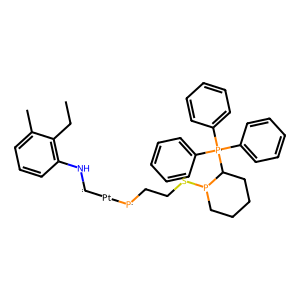

In [57]:
from rdkit import Chem
from rdkit.Chem import Draw

import numpy as np

m = Chem.MolFromSmiles(output_smi[-1])
img = Draw.MolToImage(m)
img